El presente informe corresponde al análisis exploratorio de un set de datos proporcionado por Trocafone, que consisten en un conjunto de eventos de web analytics que van desde principios de enero hasta mediados de junio. El análisis está hecho en Python 3.6.5 usando las librerías pandas (0.23.4), numpy (1.14.2), matplotlib (2.2.2), seaborn (0.9.0) y worldcloud (1.5.0).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

## Lectura y agrupamiento de los datos

In [2]:
datos = pd.read_csv('events.csv', low_memory= False)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011288 entries, 0 to 1011287
Data columns (total 23 columns):
timestamp                   1011288 non-null object
event                       1011288 non-null object
person                      1011288 non-null object
url                         82756 non-null object
sku                         563838 non-null object
model                       564284 non-null object
condition                   563836 non-null object
storage                     563836 non-null object
color                       563836 non-null object
skus                        221699 non-null object
search_term                 48967 non-null object
staticpage                  3598 non-null object
campaign_source             82796 non-null object
search_engine               50957 non-null object
channel                     87378 non-null object
new_vs_returning            87378 non-null object
city                        87378 non-null object
region                    

In [3]:
#Convertimos los valores del campo "sku" a un solo tipo, ya que hay registros que presentan igual valor y distinto tipo, e.g. "120.0" y "120"
datos = datos.sort_values(by=['person', 'timestamp'], ascending=True)
datos["sku"] = pd.to_numeric(datos["sku"], errors="coerce")

In [4]:
# Las pasamos a español para que las visualizaciones se vean en español
datos.loc[datos['condition'] == 'Bom', 'condition'] = 'Bien'
datos.loc[datos['condition'] == 'Muito Bom', 'condition'] = 'Muy Bien'
datos.loc[datos['condition'] == 'Bom - Sem Touch ID', 'condition'] = 'Bien - Sin Touch ID'
datos.loc[datos['condition'] == 'Novo', 'condition'] = 'Nuevo'

#### Creo el DF de los productos 

In [5]:
productos = datos[["sku", "model", "condition", "storage", "color", "event"]].dropna(subset=["sku"])
productos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 563836 entries, 2 to 1011287
Data columns (total 6 columns):
sku          563836 non-null float64
model        563836 non-null object
condition    563836 non-null object
storage      563836 non-null object
color        563836 non-null object
event        563836 non-null object
dtypes: float64(1), object(5)
memory usage: 30.1+ MB


In [6]:
productos_comprados = productos.loc[productos['event'] == "conversion"]
productos_vistos = productos.loc[productos['event'] == "viewed product"]

# Análisis exploratorio

Primero analizamos qué tenemos en el dataframe. Vemos las columnas, analizamos cuántos valores nulos tenemos, los nombres de los  eventos, las condiciones en las que se encuentran los productos.

## Overview del set de datos

El set de datos contiene las siguientes columnas: #acá podemos incluir la descripción las columnas tal como aparecen en el enunciado

In [7]:
datos.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Paid,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bien,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bien,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bien,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(datos.shape)

(1011288, 23)


In [9]:
datos.isnull().sum()

timestamp                         0
event                             0
person                            0
url                          928532
sku                          447452
model                        447004
condition                    447452
storage                      447452
color                        447452
skus                         789589
search_term                  962321
staticpage                  1007690
campaign_source              928492
search_engine                960331
channel                      923910
new_vs_returning             923910
city                         923910
region                       923910
country                      923910
device_type                  923910
screen_resolution            923910
operating_system_version     923910
browser_version              923910
dtype: int64

Aquí notamos que hay muchos valores nulos en la columna "staticpage", como conclusión no la usamos para los futuros análisis.

#### Eventos

Los eventos registrados en el set de datos son los siguientes: #acá iría la descripción de los eventos tal como figura en el enunciado

In [10]:
for x in datos['event'].unique():
    print (x)

ad campaign hit
visited site
viewed product
checkout
generic listing
search engine hit
brand listing
searched products
conversion
staticpage
lead


#### Condiciones en las que puede encontrarse un producto

Un producto puede encontrarse en las siguientes condiciones:

In [11]:
for x in datos['condition'].unique():
    print (x)

nan
Bien
Muy Bien
Excelente
Bien - Sin Touch ID
Nuevo


## Visualizaciones

Como vemos que hay empresas publicitarias, queremos saber cuántas visitas aportaron cada una.

### 1. Las empresas publicitarias 

In [12]:
# Cantidad de eventos por campañas publicitarias
datos_campaign_source = datos['campaign_source'].value_counts()
datos_campaign_source
datos.groupby('campaign_source').agg({'campaign_source':'count'}).sort_values('campaign_source',ascending=False)\
                .rename(columns={"campaign_source": "Cantidad de visitas"})

,Cantidad de visitas
campaign_source,
google,58153
criteo,9694
rtbhouse,8550
zanox,1673
emblue,1352
FacebookAds,764
afilio,692
bing,484
voxus,432


Se ve que hay una empresa en particular que genera gran cantidad de visitas en comparación con las otras y que hay otras que generan muy pocas. Se tendría que prestar más atención a las últimas, ya sea para promocionarlas más o dejar de invertir en esas para apoyar otras.

### Top 10 de empresas publicitarias

Text(0,0.5,'Cantidad de avisos')

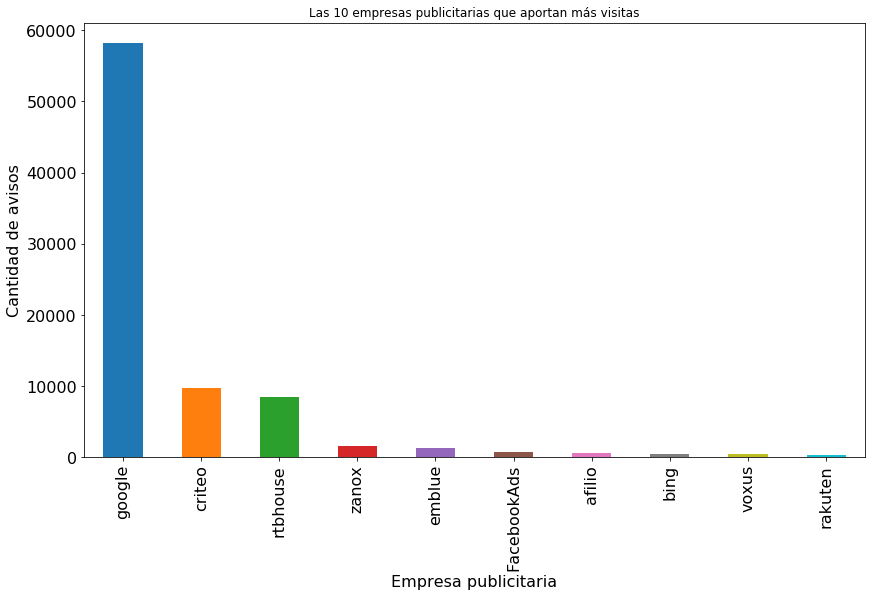

In [13]:
fig =plt.figure()
ax = datos_campaign_source[:10].plot('bar', figsize=(14,8), title='Las 10 empresas publicitarias que aportan más visitas', fontsize=16)
ax.set_xlabel('Empresa publicitaria',fontsize=16)
ax.set_ylabel('Cantidad de avisos',fontsize=16)

Conclusion: Utilizando Google como campaña publicitaria es por donde se obtienen más visitas.

### 2. Modelos más visitados

Text(0,0.5,'Modelo')

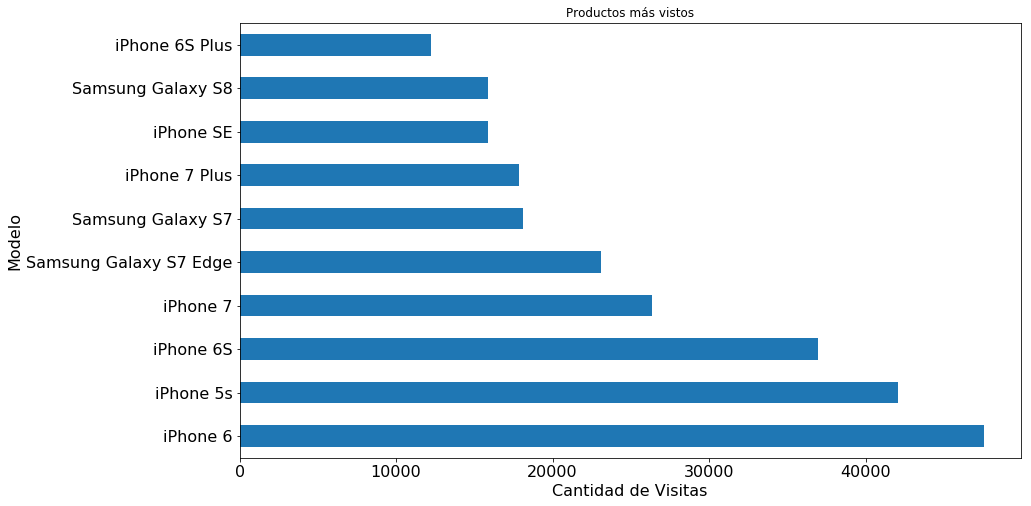

In [14]:
productos_vistos_cantidad_plot = productos_vistos[['model','event']].groupby(['model']).count()\
            .sort_values('event', ascending = False).head(10).plot(kind='barh',fontsize=16, figsize=(14,8)\
            ,rot=0, title='Productos más vistos', legend=None)
productos_vistos_cantidad_plot.set_xlabel("Cantidad de Visitas", fontsize=16)
productos_vistos_cantidad_plot.set_ylabel("Modelo", fontsize=16)

Como podemos observar en el gráfico, los teléfonos más vistos son los iPhones, seguidos por los Samsung. A su vez, todos los modelos pertencen a la gama más alta disponbile en el mercado y por ende, son los más caros (~US$200).

### 3. Modelos más comprados 

Text(0,0.5,'Modelo')

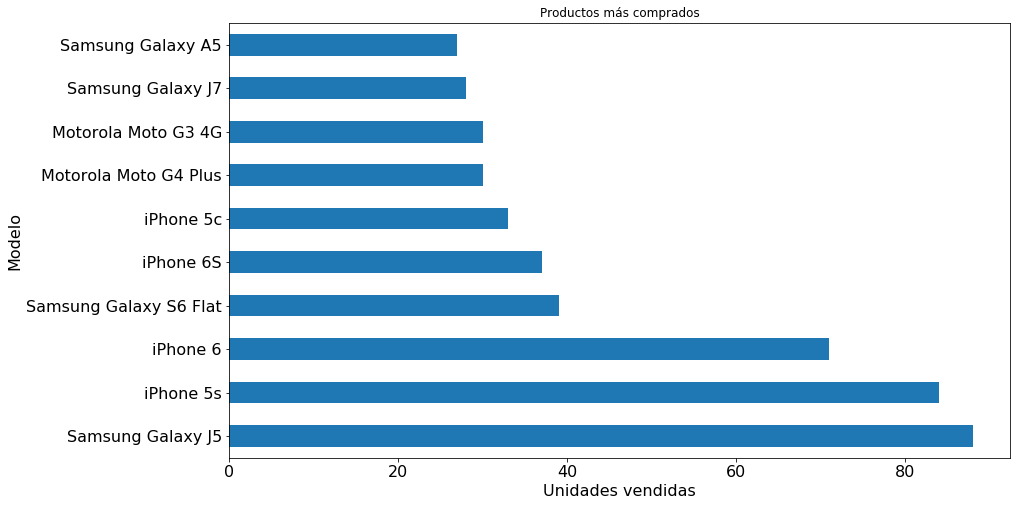

In [15]:
productos_comprados_cantidad_plot = productos_comprados[['model','event']].groupby(['model']).count()\
        .sort_values('event', ascending = False).head(10).plot(kind='barh',fontsize=16, figsize=(14,8), rot=0\
        , title='Productos más comprados', legend=None)
productos_comprados_cantidad_plot.set_xlabel("Unidades vendidas", fontsize=16)
productos_comprados_cantidad_plot.set_ylabel("Modelo", fontsize=16)

Los teléfonos más vendidos son nuevamente los iPhone y Samsung. Sin embargo en este caso el más vendido no es uno de lo teléfonos más vistos y es de un precio más accesible (~US$120).

### 4. Estado de los productos más comprados

Análisis sobre las condiciones en las que se encuentran los teléfonos comprados.

Text(0,0.5,'Modelo')

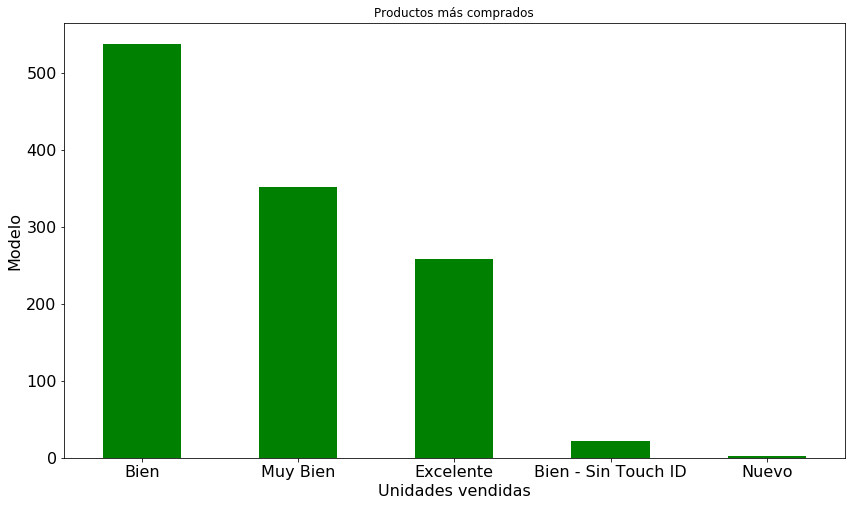

In [16]:
productos_comprados_estado_plot = productos_comprados[['condition','event']].groupby(['condition']).count()\
        .sort_values('event', ascending = False).head(10).plot(kind='bar',fontsize=16, figsize=(14,8), rot=0\
        ,color="green", title='Productos más comprados', legend=None)
productos_comprados_estado_plot.set_xlabel("Unidades vendidas", fontsize=16)
productos_comprados_estado_plot.set_ylabel("Modelo", fontsize=16)

La mayoria de los telefonos que se venden están en estado "Bien".

### 5. Estado de los productos más visitados

Text(0,0.5,'Modelo')

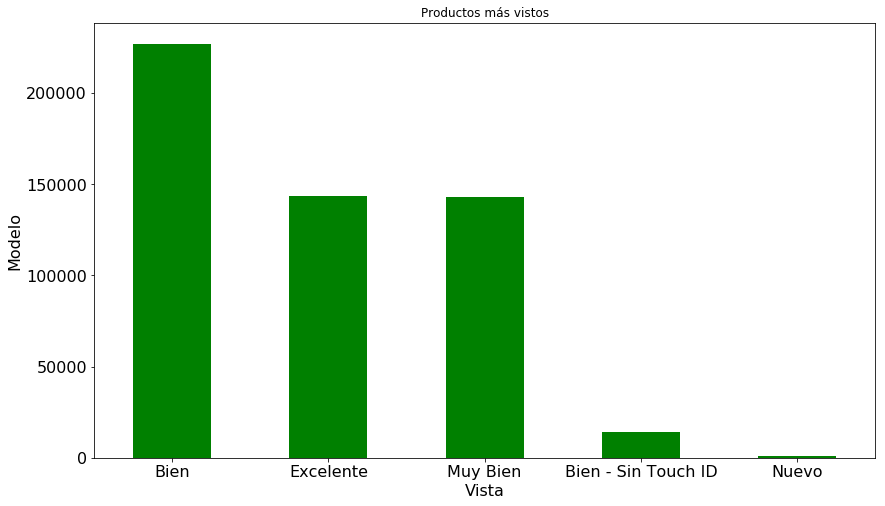

In [17]:
productos_vistos_estado_plot = productos_vistos[['condition','event']].groupby(['condition']).count()\
        .sort_values('event', ascending = False).head(10).plot(kind='bar',fontsize=16, figsize=(14,8), rot=0\
        ,color="green", title='Productos más vistos', legend=None)
productos_vistos_estado_plot.set_xlabel("Vista", fontsize=16)
productos_vistos_estado_plot.set_ylabel("Modelo", fontsize=16)

 Los teléfonos más vistos también son lo que tiene una condición de "Bien".

### 6. Proporción de productos según el estado

Realizamos este pie chart con el único propósito de comprobar que esta tendencia de los usuarios a elegir los teléfonos con el peor estado posible ("Bien") no se debe a una desproporción en la oferta. Efectivamente, hay una balanceada proporción de teléfonos en estado "Bien", "Muy Bien" y "Excelente", por lo que lo podemos concluir que los usuarios no eligen los teléfonos en estado "Bien" porque no haya teléfonos en otro estado, sino por otra causa. 
Conclusión: el estado del teléfono no es tan importante.

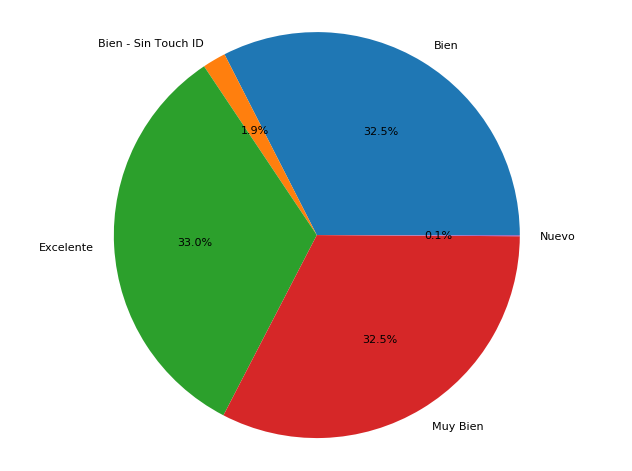

In [18]:
catalogo = productos.drop_duplicates('sku')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
catalogo_plot = catalogo[['condition', 'event']].groupby('condition').count().reset_index()
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0) 
plt.pie(catalogo_plot['event'], labels=catalogo_plot['condition'], autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.show()

### 7. ¿A qué hora son más efectivas las publicidades?

La página de Trocafone registra mayor cantidad de entradas por medio de publicidades desde media tarde hasta la medianoche, lo cual tiene sentido ya que a la madrugada la gente duerme y a la mañana la mayoría está trabajando.

Text(0,0.5,'Cantidad de Clicks en Publicidades')

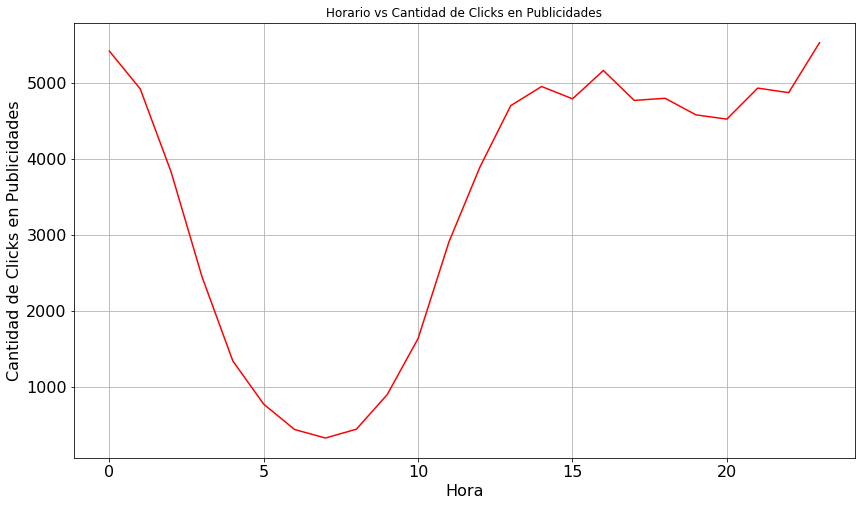

In [19]:
publicidades = datos[['timestamp', 'person']].loc[datos['event'] == 'ad campaign hit']
publicidades['timestamp'] = publicidades['timestamp'].str.split(" ").str[1].str.split(":").str[0]


publicidades_hora_plot = publicidades.groupby('timestamp').count().reset_index()\
                        .plot.line(color='red',legend=None, fontsize=16, grid=True\
                        , figsize=(14,8), rot=0 ,title='Horario vs Cantidad de Clicks en Publicidades' )
publicidades_hora_plot.set_xlabel("Hora", fontsize=16)
publicidades_hora_plot.set_ylabel("Cantidad de Clicks en Publicidades", fontsize=16)

### 8. Los eventos que derivan en una compra

 Para realizar este análisis se creó un nuevo dataframe de "Sesiones" llamado "flujo_compra". Una sesión registra los movimientos de un usuario en un período de una hora. Se consideró que como máximo una sesión puede durar cuatro horas, es decir que si un usuario entra a la página de trocafone en un mismo día pero en distinto horario (a la mañana y a la noche), generará dos registros distintos. Además, si un usuario realiza una compra (evento conversion) la sesión termina y los eventos posterios serán considerados como parte de otra sesión, optamos por esta implementación para más adelante agregar una columna del tipo "Compró/No Compró". Si bien solo estamos considerando el evento inicial y el final, creemos que con algunas modificaciones este dataframe puede más adelante aportar información más interesante.

In [20]:
from datetime import datetime
def mostrar(df):    
    rows = []
    person = ""    
    for index, row in df.iterrows():  
        if(person == ""):
            person = row["person"]
            first_event_time = row["timestamp"]
            first_event_name = row["event"]
            final_event_time = row["timestamp"]
            final_event_name = row["event"]                        
            continue
        if(person != row["person"] or (datetime.strptime(row['timestamp'],"%Y-%m-%d %H:%M:%S") - datetime.strptime(first_event_time,"%Y-%m-%d %H:%M:%S")).total_seconds() > 14400):
            rows.append([person, first_event_name, first_event_time, final_event_name, final_event_time])
            person = row["person"]
            first_event_time = row["timestamp"]
            first_event_name = row["event"]    
            final_event_time = row["timestamp"]
            final_event_name = row["event"]
            if (row["event"] =="conversion"):
                rows.append([person, first_event_name, first_event_time, final_event_name, final_event_time])
                person = ""
        else:
            final_event_time = row["timestamp"]
            final_event_name = row["event"]
            if(row["event"] == "conversion"):
                rows.append([person, first_event_name, first_event_time, final_event_name, final_event_time])
                person = ""
    return pd.DataFrame(rows,columns=('person', 'first_event', 'first_event_time', 'final_event', 'final_event_time'))

In [21]:
flujo_compra = mostrar(datos[['timestamp', 'event', 'person']].sort_values(by=['person', 'timestamp'], ascending=True))

In [22]:
flujo_compra = flujo_compra.loc[flujo_compra['first_event_time'] != flujo_compra['final_event_time']]
flujo_compra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69544 entries, 0 to 75942
Data columns (total 5 columns):
person              69544 non-null object
first_event         69544 non-null object
first_event_time    69544 non-null object
final_event         69544 non-null object
final_event_time    69544 non-null object
dtypes: object(5)
memory usage: 3.2+ MB


In [23]:
termina_en_compra = flujo_compra.loc[flujo_compra['final_event']=='conversion']

Text(0,0.5,'Evento')

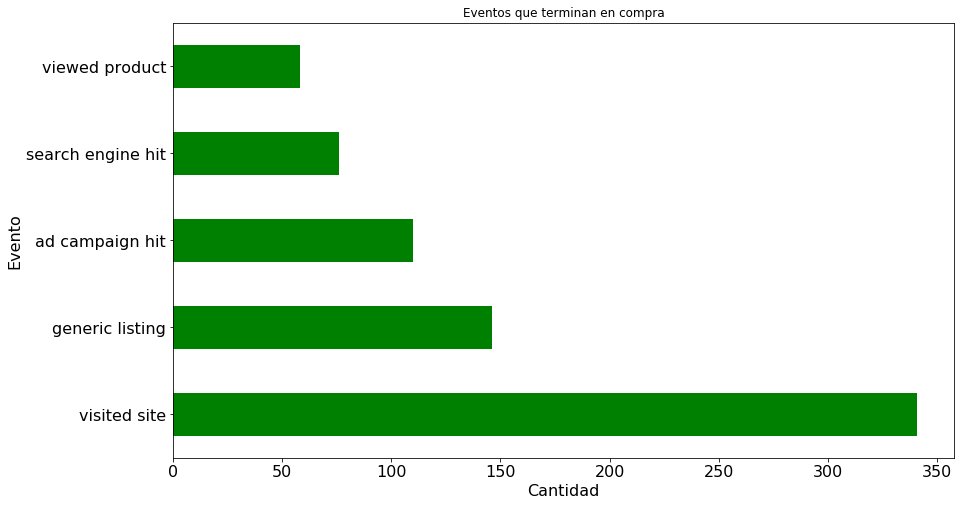

In [24]:
termina_en_compra.groupby('first_event').count()
eventos_compra_plot = termina_en_compra[['first_event','first_event_time']].groupby(['first_event']).count()\
        .sort_values('first_event_time', ascending = False).head(5).plot(kind='barh',fontsize=16, figsize=(14,8), rot=0\
        ,color="green", title='Eventos que terminan en compra', legend=None)
eventos_compra_plot.set_xlabel("Cantidad", fontsize=16)
eventos_compra_plot.set_ylabel("Evento", fontsize=16)

La mayoría de las ventas concretadas comenzaron con el evento "visited site", sin embargo podemos destacar con un tercio de las ventas comenzaron con un click en una publicidad (evento "ad campaign hit")

### 9. Registraciones de los usuarios

In [25]:
# Tomamos la fecha de registración de los usuarios
nuevos = datos.loc[datos['new_vs_returning'] == 'New']
usuarios_nuevos = nuevos[['person','timestamp']]
usuarios_nuevos.rename(columns={'timestamp':'fecha_registro'},inplace=True)
usuarios_nuevos.head(5)

,person,fecha_registro
1,0004b0a2,2018-05-31 23:38:05
5,0006a21a,2018-05-29 13:29:26
9,000a54b2,2018-04-09 20:12:31
45,00184bf9,2018-04-06 05:12:05
96,0019c395,2018-05-17 00:08:56


In [26]:
usuarios_nuevos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26898 entries, 1 to 1011284
Data columns (total 2 columns):
person            26898 non-null object
fecha_registro    26898 non-null object
dtypes: object(2)
memory usage: 630.4+ KB


El siguiente heatmap describe la registración de nuevos usuario a lo largo del tiempo. La web incrementó gradualmente la cantidad de usuarios nuevos por mes, teniendo su pico en los meses de Junio y Julio. También se puede apreciar los días con mayor cantidad de registraciones, lunes, martes y miércoles. 

[Text(0,0.5,'Lunes'),
 Text(0,1.5,'Martes'),
 Text(0,2.5,'Miercoles'),
 Text(0,3.5,'Jueves'),
 Text(0,4.5,'Viernes'),
 Text(0,5.5,'Sábado'),
 Text(0,6.5,'Domingo')]

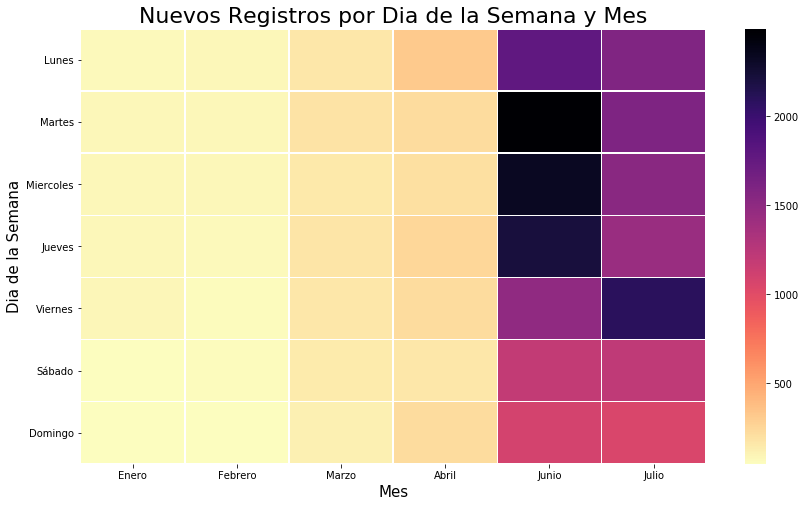

In [27]:
nuevas_registraciones = usuarios_nuevos[['person','fecha_registro']]
nuevas_registraciones['fecha_registro'] = pd.to_datetime(nuevas_registraciones['fecha_registro'])
nuevas_registraciones['Mes'] = nuevas_registraciones['fecha_registro'].dt.month
nuevas_registraciones['Dia'] = nuevas_registraciones['fecha_registro'].dt.dayofweek
nuevas_registraciones['Cantidad'] = 1
nuevas_registraciones['Mes'] = nuevas_registraciones['Mes'] - 1

Dias = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sábado','Domingo']
Meses = ['Enero','Febrero','Marzo','Abril','Junio','Julio']
nuevas_registraciones['Dia'] = nuevas_registraciones['Dia'].apply(lambda x: Dias[x])
nuevas_registraciones['Mes'] = nuevas_registraciones['Mes'].apply(lambda x: Meses[x])


table = nuevas_registraciones.pivot_table(index='Dia',columns='Mes',aggfunc=np.sum)
table.columns = table.columns.droplevel(0)
table = table[Meses]
table = table.reindex(index = Dias)

plt.subplots(figsize=(14,8))
grafico_semana=sns.heatmap(table,linewidths=.5,cmap="magma_r")
grafico_semana.set_title("Nuevos Registros por Dia de la Semana y Mes",fontsize=22)
grafico_semana.set_xlabel("Mes",fontsize=15)
grafico_semana.set_ylabel("Dia de la Semana",fontsize=15)
grafico_semana.set_yticklabels(grafico_semana.get_yticklabels(),rotation=0)

Text(0.5,1,'Cantidad de registraciones por dia')

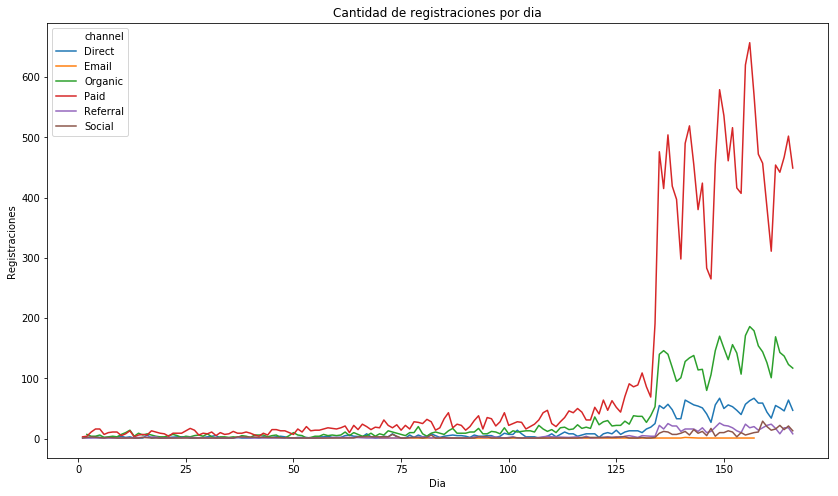

In [28]:
canales_usuarios_nuevos = datos.loc[datos['new_vs_returning'] == 'New']
canales_usuarios_nuevos = canales_usuarios_nuevos[['person','timestamp','channel']]

canales_usuarios_nuevos['timestamp'] = pd.to_datetime(canales_usuarios_nuevos['timestamp'])
canales_usuarios_nuevos ['Dia'] = canales_usuarios_nuevos['timestamp'].dt.dayofyear

canales_usuarios_nuevos['Registraciones'] = 0
canales_usuarios_nuevos = canales_usuarios_nuevos.groupby(['channel','Dia'])['Registraciones']\
                                                                                            .count().reset_index()
canales_usuarios_nuevos = canales_usuarios_nuevos.loc[canales_usuarios_nuevos['channel'] != 'Unknown']
plt.subplots(figsize=(14,8))
sns.lineplot(x='Dia',y='Registraciones',hue='channel',data=canales_usuarios_nuevos)\
                                                                .set_title("Cantidad de registraciones por dia")


Los canales se comportan de manera parecida, siendo el canal de pago el que más usuarios generó. El mayor alza se encuentra luego de mediados de Mayo (día 130) y el pico más alto de usuarios en el mes de Junio cómo en el anterior gráfico.

### 10. Eventos de los no usuarios

In [29]:
# Tomamos la fecha del primer regreso a la página
regreso = datos.loc[datos['new_vs_returning'] == 'Returning']
primer_regreso = regreso.sort_values('timestamp',ascending=True).drop_duplicates('person')
usuarios_primer_regreso = primer_regreso[['person','timestamp']]
usuarios_primer_regreso.rename(columns={'timestamp':'fecha_primer_regreso'},inplace=True)
usuarios_primer_regreso.head(5)

,person,fecha_primer_regreso
543842,8b6dbd1d,2018-01-01 12:40:21
644817,a51a7fa8,2018-01-02 15:59:53
571679,9250d410,2018-01-02 19:45:05
41369,0b9456e3,2018-01-02 20:40:38
796576,cbaee231,2018-01-03 03:59:38


In [30]:
# Mergeamos las fechas
usuarios_nuevos = pd.merge(usuarios_nuevos,usuarios_primer_regreso,on='person',how='left')
usuarios_nuevos.head(5)

,person,fecha_registro,fecha_primer_regreso
0,0004b0a2,2018-05-31 23:38:05,NaN
1,0006a21a,2018-05-29 13:29:26,NaN
2,000a54b2,2018-04-09 20:12:31,2018-05-24 11:21:07
3,00184bf9,2018-04-06 05:12:05,2018-05-04 18:47:03
4,0019c395,2018-05-17 00:08:56,NaN


In [31]:
# Tomamos los id de las personas que no se volvieron a logear
usuarios_nuevos.fillna('empty',inplace=True)
usuarios_casuales = usuarios_nuevos.loc[usuarios_nuevos['fecha_primer_regreso']=='empty']
usuarios_casuales.drop(columns=['fecha_registro','fecha_primer_regreso'],inplace=True)

In [32]:
#Agregamos las fechas al dataframe datos
datos_fechas_importantes = pd.merge(datos,usuarios_nuevos,on='person',how='inner')


In [33]:
# Nos quedamos con los eventos previos a la fecha de registro.
primeros_pasos = datos_fechas_importantes.loc[datos_fechas_importantes['timestamp']\
                                              <=datos_fechas_importantes['fecha_registro']]
# Sacamos los visited site que significan registros nuevos. Se pierden cerca de 3000 usuarios,
# que no poseen información de los eventos previos al registro.
# No se hizo en el paso anterior porque hay eventos que comparten la misma hora que la fecha de registro.
primeros_pasos = primeros_pasos.loc[primeros_pasos['new_vs_returning'] != 'New']
us = primeros_pasos.drop_duplicates('person')
print("Usuarios con eventos previos al registro: ",us.person.count(),"\n")
print("Usuarios totales: ",usuarios_nuevos.person.count())

Usuarios con eventos previos al registro:  24022 

Usuarios totales:  26898


Text(0,0.5,'Eventos')

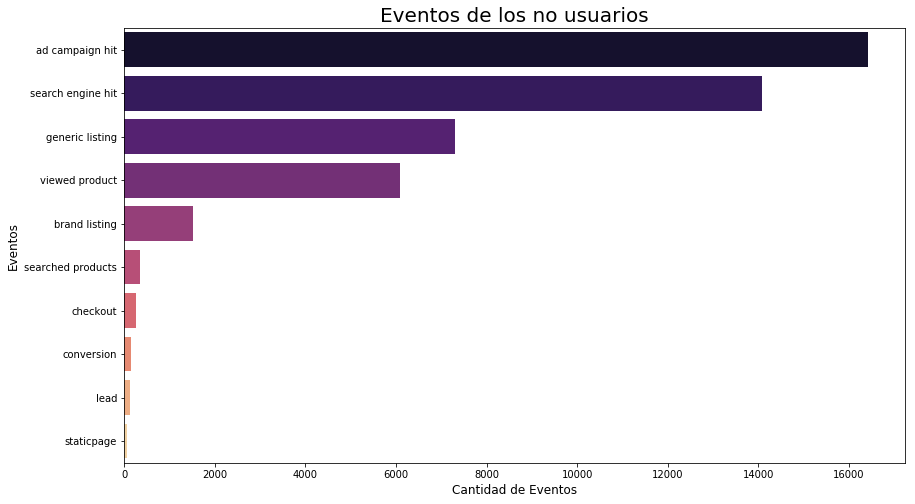

In [34]:
top_eventos=primeros_pasos['event'].value_counts()
plt.subplots(figsize=(14,8))
grafico_top_avisos=sns.barplot(x=top_eventos.values,y=top_eventos.index,orient='h',palette="magma")
grafico_top_avisos.set_title("Eventos de los no usuarios",fontsize=20)
grafico_top_avisos.set_xlabel("Cantidad de Eventos",fontsize=12)
grafico_top_avisos.set_ylabel("Eventos",fontsize=12)

Las campañas de avisos online y los buscadores son los principales eventos de los no registrados a la web.

In [35]:
# Los eventos quedaran ordenados por tiempo de aparición

primeros_pasos = primeros_pasos.sort_values(by=['timestamp'],ascending=True)
primeros_pasos_eventos = primeros_pasos[['person','event']]

# Creamos un diccionario del estilo {persona:[eventos_realizados]}
dic_person_event = {}
for index, row in primeros_pasos_eventos.iterrows():
    evento = row['event']
    persona = row['person']
    if (persona not in dic_person_event):
        dic_person_event[persona] = [evento]
    else:
        #if (evento not in dic_person_event[persona]):
            dic_person_event[persona].append(evento)

In [36]:
# Iteramos sobre el diccionario, armando otro con la cantidad de apariciones de cada combinación de eventos
dic_eventos = {}
for id in dic_person_event:
    eventos = dic_person_event[id]
    evento = ' | '.join(eventos)
    if (evento not in dic_eventos):
        dic_eventos[evento] = 1
    else:
        dic_eventos[evento] += 1

df_eventos = pd.DataFrame(list(dic_eventos.items()), columns=['eventos','cantidad'])
df_eventos = df_eventos.sort_values(by=['cantidad'], ascending=False).reset_index()
df_eventos = df_eventos[['eventos', 'cantidad']]

Trace de los eventos de los no registrados antes de ser hacerse nuevos usuarios

In [37]:
print('Total : ',df_eventos.cantidad.sum())
df_eventos['porcentage'] = df_eventos['cantidad'] / df_eventos.cantidad.sum() * 100
df_eventos.head(10)

Total :  24022


,eventos,cantidad,porcentage
0,ad campaign hit,4407,18.345683
1,search engine hit,2590,10.781783
2,ad campaign hit | search engine hit,1746,7.268337
3,search engine hit | ad campaign hit,1736,7.226709
4,viewed product | ad campaign hit,1286,5.353426
5,generic listing,1270,5.286820
6,ad campaign hit | viewed product,1267,5.274332
7,generic listing | search engine hit,1210,5.037049
8,search engine hit | generic listing,1071,4.458413
9,generic listing | search engine hit | ad campa...,530,2.206311


Observamos que aproximadamente un %18 de los usuarios se registra directamente luego de entrar a la página por una campaña de marketing y el %10  luego de haber entrado por el buscador.

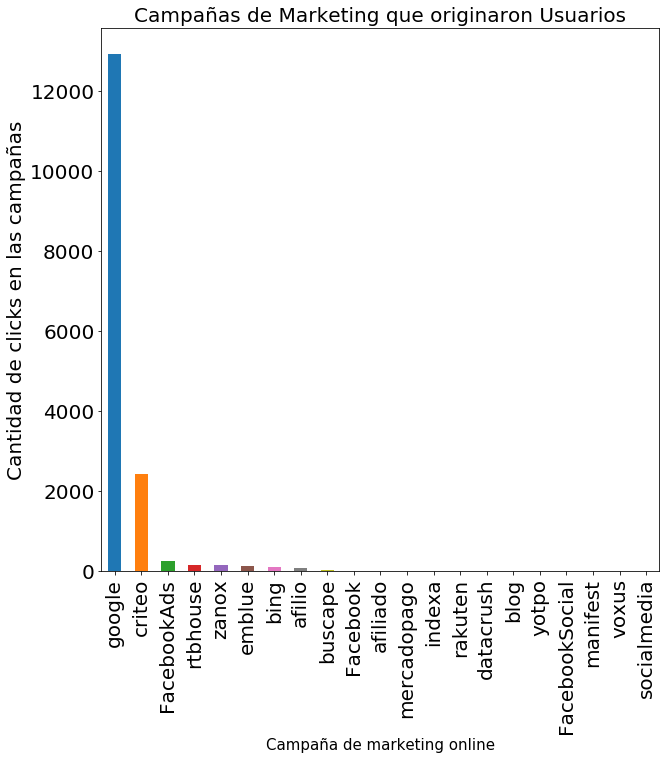

In [38]:
values = primeros_pasos.loc[primeros_pasos['event'] == 'ad campaign hit']
plt.subplots(figsize=(14,8))
values['campaign_source'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Campaña de marketing online', fontsize=15);
plt.ylabel('Cantidad de clicks en las campañas', fontsize=20)
plt.title('Campañas de Marketing que originaron Usuarios', fontsize=20);

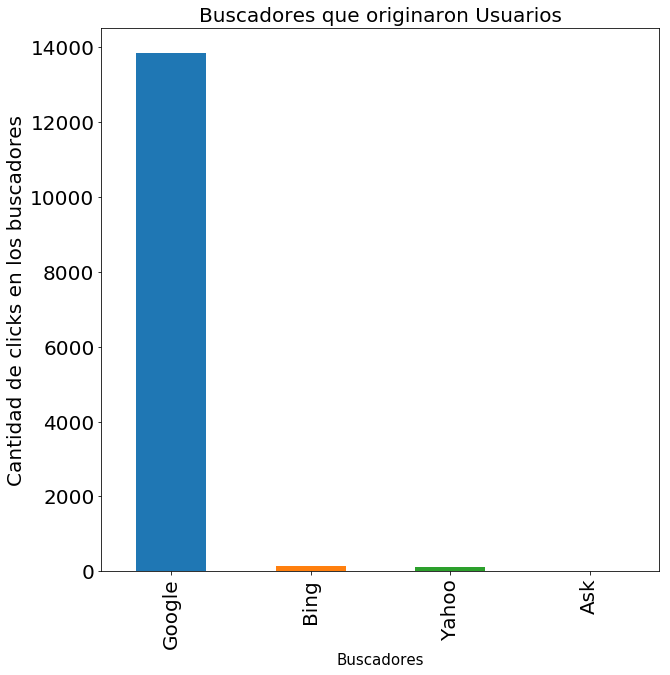

In [39]:
values = primeros_pasos.loc[primeros_pasos['event'] == 'search engine hit']
plt.subplots(figsize=(14,8))
values['search_engine'].value_counts(sort=True).plot.bar(figsize=(10,10), fontsize=20);
plt.xlabel('Buscadores', fontsize=15);
plt.ylabel('Cantidad de clicks en los buscadores', fontsize=20)
plt.title('Buscadores que originaron Usuarios', fontsize=20);

Se puede observar que las campañas marketing de Google y su buscador fue lo más predominante para la generación de usuarios. También se puede destacar Criteo como campaña de marketing.

### 11. Primer sesión de los usuarios activos y casuales

In [40]:
#Nos quedamos con la primer sesion de los usuarios activos y casuales luego del registro en la web
primer_sesion = datos_fechas_importantes.loc[(datos_fechas_importantes['timestamp']>datos_fechas_importantes['fecha_registro'])\
                                            & ( (datos_fechas_importantes['timestamp']<datos_fechas_importantes['fecha_primer_regreso'])\
                                              | (datos_fechas_importantes['fecha_primer_regreso'] == 'empty') )]
primer_sesion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267472 entries, 2 to 1008789
Data columns (total 25 columns):
timestamp                   267472 non-null object
event                       267472 non-null object
person                      267472 non-null object
url                         15174 non-null object
sku                         175334 non-null float64
model                       175367 non-null object
condition                   175334 non-null object
storage                     175334 non-null object
color                       175334 non-null object
skus                        65417 non-null object
search_term                 16450 non-null object
staticpage                  726 non-null object
campaign_source             15183 non-null object
search_engine               10664 non-null object
channel                     0 non-null object
new_vs_returning            0 non-null object
city                        0 non-null object
region                      0 non-null obje

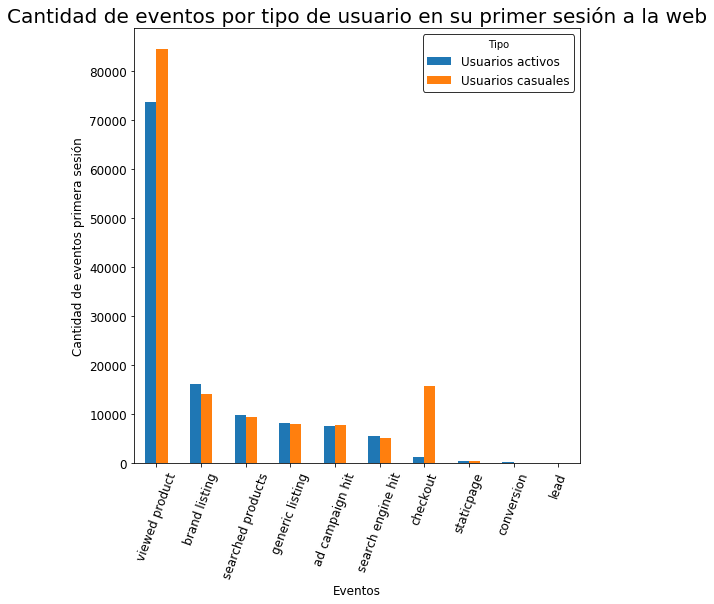

In [41]:
primer_nuevos_casuales = primer_sesion[['event','person','fecha_primer_regreso']]
primer_nuevos_casuales.rename(columns={'fecha_primer_regreso':'user_type'},inplace=True)
primer_nuevos_casuales.loc[(primer_nuevos_casuales['user_type'] != 'empty'),'user_type'] = 'Usuario Activo'
primer_nuevos_casuales.loc[(primer_nuevos_casuales['user_type'] == 'empty'),'user_type'] = 'Usuario Casual'

primer_nuevos_casuales['person'] = 1
table = primer_nuevos_casuales.pivot_table(index='event',columns='user_type',aggfunc=np.sum)
table.columns = table.columns.droplevel(0)
table.reset_index(level=[0],inplace=True)
table = table.sort_values('Usuario Activo',ascending=False)
grafico_comp_post_vista=table.plot(kind='bar',x='event',fontsize=12,figsize=(8,8),rot=70)
grafico_comp_post_vista.set_title("Cantidad de eventos por tipo de usuario en su primer sesión a la web",fontsize=20)
grafico_comp_post_vista.set_xlabel("Eventos",fontsize=12)
grafico_comp_post_vista.set_ylabel("Cantidad de eventos primera sesión",fontsize=12)
leyenda=plt.legend(['Usuarios activos','Usuarios casuales'],fontsize=12,title='Tipo',frameon=True,facecolor='white',edgecolor='black')
leyenda.get_frame().set_linewidth(1.0)

Podemos notar una similitud en los eventos de ambos tipos de usuarios, con excepción del checkout, dónde predominan los usuarios con solo una sesión. Esto no influye en la compra de productos, ya que los usuarios 'activos' tienen mayor conversión, aunque se puede notar que en su primer sesión hay una muy pobre cantidad de conversiones.

### 12. Relacion entre los eventos

En la correlación de los eventos se destaca el feature viewed product cómo el de mayor relación con los demás eventos, menos con las conversiones y por el contrario el feature lead es el de menor relación debido a su cantidad de nulos.
Nuevamente los avisos de campaña son los que mas se relacionan con las sesiones ('visited site') y los buscadores se relacionan más con las visitas al home, a las marcas y a los productos ('generic listing', 'brand listing' y 'viewed product'). Se puede suponer que los usuarios luego de registrarse por campañas de marketing, utilizan más los buscadores para entrar a las distintas partes del sitio. 

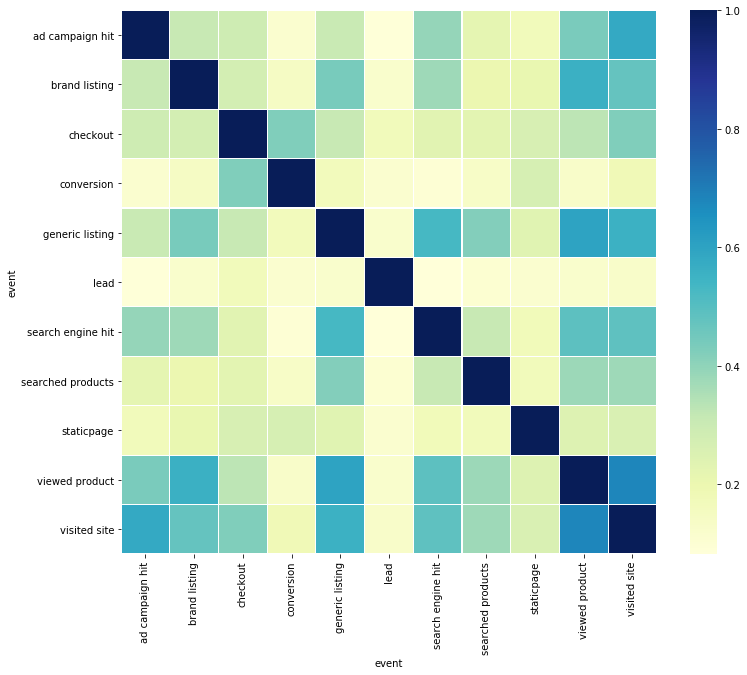

In [43]:
eventos_x_persona = datos[['person','event','timestamp']]
eventos_x_persona = eventos_x_persona.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_persona = eventos_x_persona.unstack(-1)
eventos_x_persona.columns = eventos_x_persona.columns.droplevel(0)
eventos_x_persona = eventos_x_persona.reset_index(level=0,drop=False)
eventos_x_persona = eventos_x_persona.fillna(0)
corrmat = eventos_x_persona.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

La cantidad de eventos por usuario queda acumulada entre 0 y 200, exceptuando los productos visitados que se extienden a 800 eventos por usuario. Entre los valores mas bajos estan los checkout, conversiones y lead, sin ningún usuario que sobrepase los estándares.

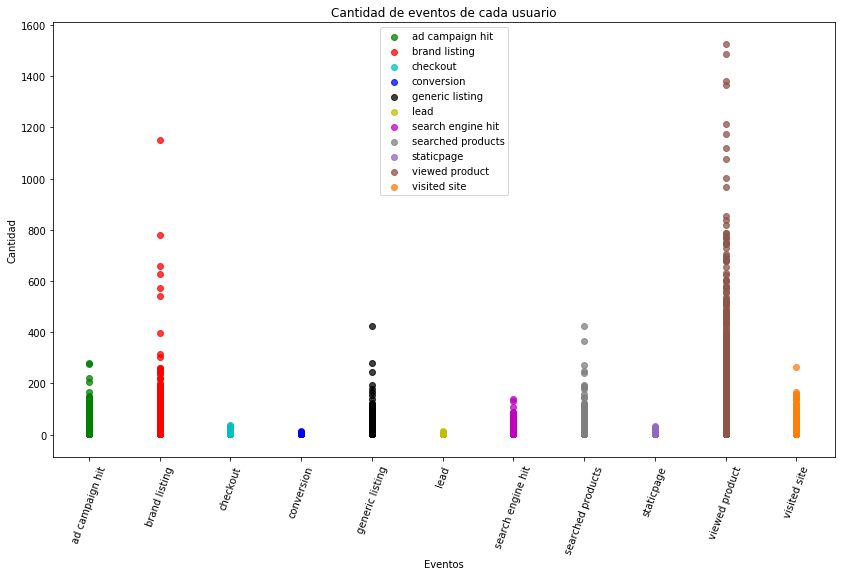

In [44]:
g = datos[['event','person','timestamp']]
g = g.groupby(['event','person']).count().reset_index()
g = g[['timestamp','event']]

names = list(g['event'].unique())
colors =["g","r","c","b","k","y","m","tab:grey","tab:purple","tab:brown","tab:orange"]
plt.figure(figsize=(14,8))
for i in range(0 , len(names)):
    data = g.loc[g['event'] == names[i]]
    plt.scatter('event', 'timestamp', data=data,color=colors[i],label=names[i],alpha=0.75)
ax=plt.gca()
ax.set_title('Cantidad de eventos de cada usuario')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Eventos')
plt.xticks(rotation=70)
plt.legend()
plt.show()

Podemos notar que a pesar de la suba en la actividad de la página y la cantidad de checkouts por quincena, la cantidad de conversiones no aumenta.

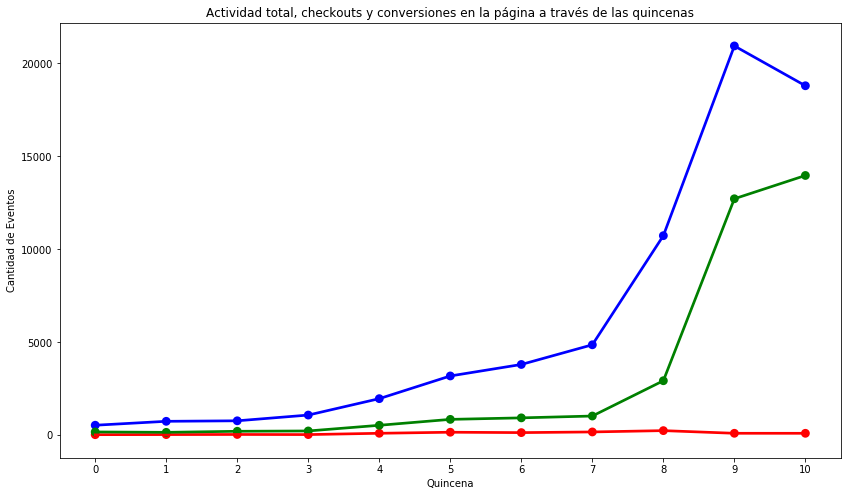

In [45]:
# LA ACTIVIDAD TOTAL DE LA WEB QUEDA EN ESCALA REDUCIDA PARA NOTAR LAS CURVAS DE LAS CONVERSIONES.

g = datos[['person','timestamp','event']]
quincenas = [False,0,2,4,6,8,10]


g['timestamp'] = pd.to_datetime(g['timestamp'])
g['Mes'] = g['timestamp'].dt.month
g['Dia'] = g['timestamp'].dt.day
g['Mes'] = g['Mes'].apply(lambda x: quincenas[x])
g.loc[g['Dia'] < 16,'Dia'] = 0
g.loc[g['Dia'] > 15,'Dia'] = 1
g['Quincena'] = g['Dia'] + g['Mes']

g['Conversiones'] = 0
g['Checkouts'] = 0
g.loc[g['event'] == 'conversion','Conversiones'] = 1
g.loc[g['event'] == 'checkout','Checkouts'] = 1
g['Cantidad de eventos'] = 0
g = g.groupby('Quincena').agg({'Cantidad de eventos':'count','Conversiones':'sum','Checkouts':'sum'}).reset_index()
g['Cantidad de eventos'] /= 15


fig, ax = plt.subplots(figsize=(14,8))


sns.pointplot(x='Quincena', y='Cantidad de eventos', data=g, ax=ax, color='b')
sns.pointplot(x='Quincena', y='Conversiones', data=g, ax=ax, color='r')
sns.pointplot(x='Quincena', y='Checkouts', data=g, ax=ax, color='g')

labels = ax.get_xticklabels()
ax.set_title('Actividad total, checkouts y conversiones en la página a través de las quincenas')
ax.set_ylabel('Cantidad de Eventos')
plt.show()


### 13. Términos más utilizados en las búsquedas

Este gráfico (realizado con la librería wordcloud) muestra los términos más buscados, podemos ver que los más buscados son los Iphones, sobre todo los modelos 5s y 6s. En menor medida se busca modelos de Samsung y Motorola. Esto claramente es coherente con los gráficos de los modelos más comprados y más vistos (Apple y Samsung).

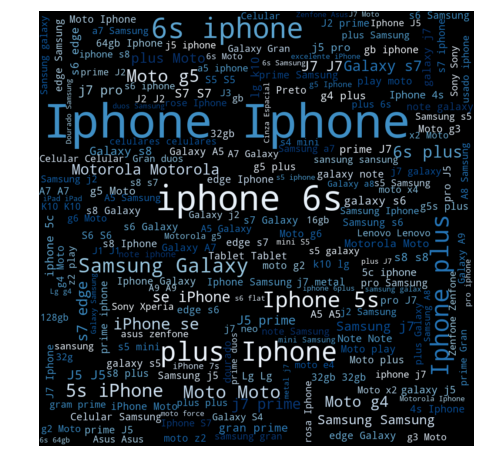

In [46]:
words = datos['search_term'].dropna()
words = ' '.join(words)

plt.subplots(figsize=(14,8))
wordcloud = WordCloud(width=1000,height=1000, margin=0,colormap="Blues").generate(words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### 14. Países con mayor actividad

El país con mayor cantidad de eventos es definitivamente Brasil (dado que de allí proviene la página) sin embargo es destacable que Estados Unidos y Canadá también registren eventos. Dado que Estados Unidos es el segundo pais con más eventos, la página podría recibir más atención si contara con una versión en inglés. 

In [47]:
pais = datos[["event", "country"]].loc[datos["event"] == "visited site"]
pais = pais.loc[pais["country"]!= "Unknown"]
pais.groupby("country").count()\
        .sort_values('event', ascending = False).head(5)

,event
country,
Brazil,84308
United States,465
Argentina,94
Canada,35
Netherlands,13


### 15. Resolución de pantalla

La resolucion más usada por los dispositivos inteligentes es 360x640, esto es importante para que el sitio este preparado perfectamente para el uso de dichas resoluciones, qué por lo visto son todas resoluciones pequeñas.

Text(0,0.5,'Pantallas')

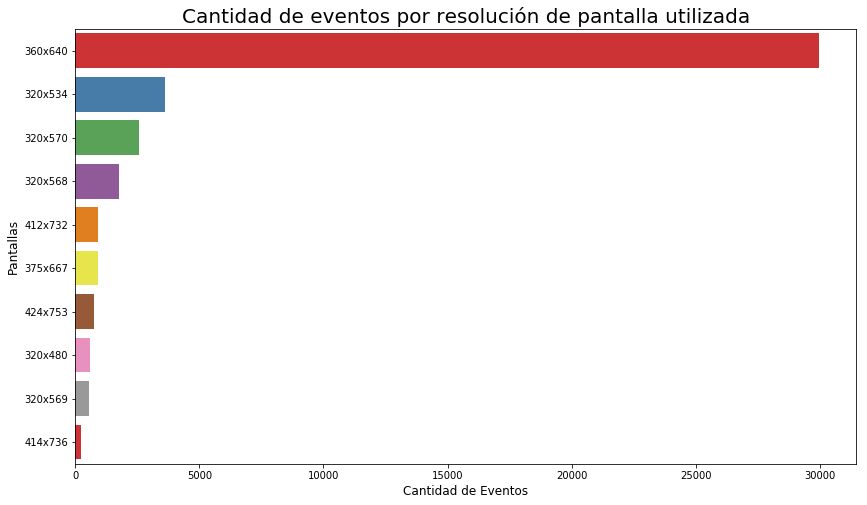

In [69]:
top_screens = datos.loc[datos['device_type'] == 'Smartphone']
top_screens = top_screens['screen_resolution'].value_counts().head(10)
plt.subplots(figsize=(14,8))
grafico_top = sns.barplot(x=top_screens.values,y=top_screens.index,palette="Set1")
grafico_top.set_title("Cantidad de eventos por resolución de pantalla utilizada",fontsize=20)
grafico_top.set_xlabel("Cantidad de Eventos",fontsize=12)
grafico_top.set_ylabel("Pantallas",fontsize=12)